In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
import _pickle as pickle
import seaborn as sns
import random
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE


In [302]:
raw_df = pd.read_csv("processed_data/tfidf_df.csv")
vectorizer = pickle.load(open("processed_data/tfidf_vectorizer.pkl", "rb"))
y_map = {k: i for i, k in enumerate(raw_df.topic_area.unique())}
raw_df.topic_area = raw_df.topic_area.apply(lambda x: y_map[x])


In [314]:
## https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas
def stratified_sample_df(df, col, n_samples, random_state=69, save=False):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n, random_state=random_state))
    df_.index = df_.index.droplevel(0)
    if save:
        df_.to_csv("processed_data/tfidf_df_random.csv")
    return df_


def cnn_sample_df(df, random_state=69, save=False):
    cnn = CondensedNearestNeighbour(
        random_state=random_state, sampling_strategy="majority"
    )
    X, y = cnn.fit_resample(df.iloc[:, :-1], df.iloc[:, -1])
    res = X.copy()
    res["topic_area"] = y.tolist()
    if save:
        res.to_csv("processed_data/tfidf_df_cnn.csv")
    return res


def smote_sample_df(df, random_state=69, save=False):
    smote = SMOTE(random_state=random_state)
    X, y = smote.fit_resample(df.iloc[:, :-1], df.iloc[:, -1])
    res = X.copy()
    res["topic_area"] = y.tolist()
    if save:
        res.to_csv("processed_data/tfidf_df_smote.csv")
    return res


In [315]:
## random undersampling
df = stratified_sample_df(raw_df, "topic_area", 50)

## condensed nearest neighbours
# df = cnn_sample_df(raw_df)

## smote oversampling
# df = smote_sample_df(raw_df)


X = df.iloc[:, :-1]
y = df.iloc[:, -1]


In [316]:
y.value_counts()

0    10000
1    10000
2    10000
3    10000
4    10000
5    10000
6    10000
Name: topic_area, dtype: int64

In [317]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=69
)


In [318]:
model = XGBClassifier(
    objective="multi:softmax",
    num_class=len(y_train.unique()),
    colsample_bytree=0.2,
    subsample=0.7,
    random_state=69,
    max_depth=4,
    eval_metric="merror",
    use_label_encoder=False,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)


/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [319]:
pickle.dump(model, open("saved_models/tfidf_model.pkl", "wb"))


In [320]:
accuracy = metrics.accuracy_score(y_test, y_pred)
roc = metrics.roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
class_report = metrics.classification_report(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)


# Visualisations

In [321]:
print(class_report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000
           2       1.00      1.00      1.00      2000
           3       1.00      1.00      1.00      2000
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00      2000
           6       1.00      1.00      1.00      2000

    accuracy                           1.00     14000
   macro avg       1.00      1.00      1.00     14000
weighted avg       1.00      1.00      1.00     14000



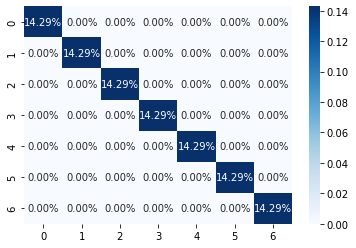

In [322]:
## Confusion Matrix
sns.heatmap(
    confusion_matrix / np.sum(confusion_matrix), fmt=".2%", annot=True, cmap="Blues"
)
plt.show()


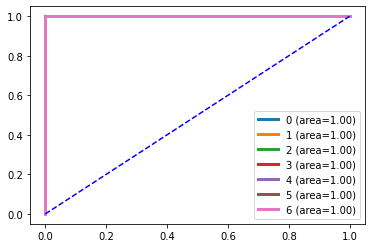

In [323]:
## https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
classes = y.unique()
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:, i], y_pred_prob[:, i])
    ax.plot(
        fpr,
        tpr,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(fpr, tpr)),
    )
ax.plot([0, 1], [0, 1], color="blue", linestyle="--")
ax.legend()


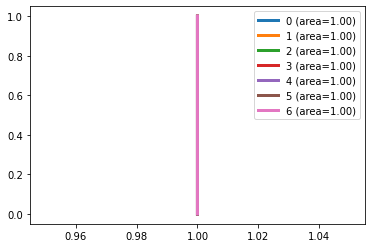

In [324]:
classes = y.unique()
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:, i], y_pred_prob[:, i]
    )
    ax.plot(
        precision,
        recall,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(recall, precision)),
    )
ax.legend()
